<a href="https://colab.research.google.com/github/PaiYS/soli-dataset/blob/master/pai_ts_cnnlstm_3g62f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#increase VRAM limit for COLAB
a = []
while(1):
    a.append('1')

In [0]:
#overcome keras tf version error for colab
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0-rc3
tf.keras.__version__ is: 2.3.0-tf


In [0]:
import os
from numpy import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, TimeDistributed, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling2D, MaxPooling3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.engine.input_layer import Input
from keras.utils import to_categorical
from keras.layers import merge, Add, Activation, Dense, Concatenate, average
from keras import optimizers
from keras.regularizers import l1
from scipy import signal
from numpy import asarray
from numpy import save
import pylab as plt

In [0]:
no_of_gestures = 3
no_of_samples = 240
frames = 62

In [0]:
#pull dataset from github
! git clone https://github.com/PaiYS/soli-dataset.git

Cloning into 'soli-dataset'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 544 (delta 0), reused 0 (delta 0), pack-reused 540
Receiving objects: 100% (544/544), 213.94 MiB | 40.40 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (720/720), done.


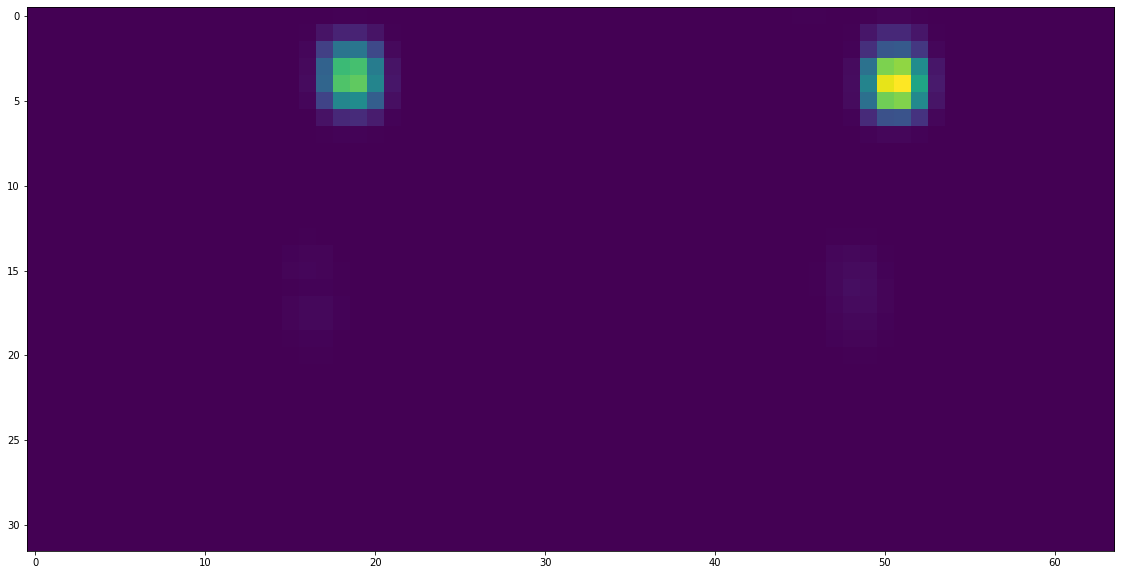

In [0]:
checkdata = np.load('soli-dataset/g2-g5-g8/abs/abs_data_p2_g2_5.npy')
plt.figure(figsize = (30,10))
plt.imshow(checkdata[31][0])

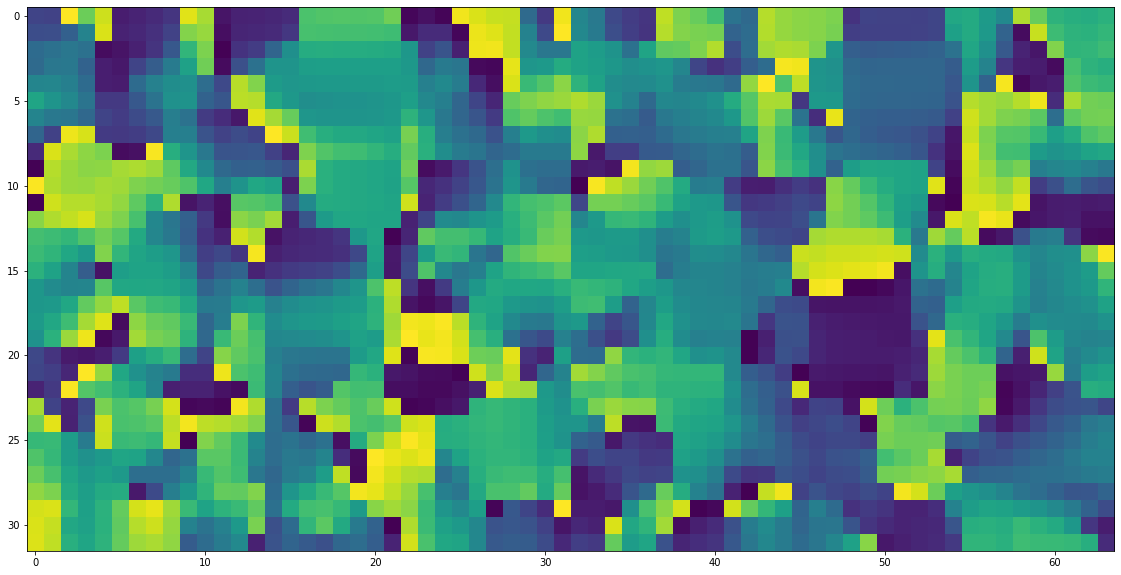

In [0]:
checkdata = np.load('soli-dataset/g2-g5-g8/phs/phs_data_p2_g2_5.npy')
plt.figure(figsize = (30,10))
plt.imshow(checkdata[31][0])

In [0]:
checkdata.shape

(62, 1, 32, 64)

In [0]:
datafiles = []
for i in os.listdir('soli-dataset/g2-g5-g8/abs/'):
    if i.startswith('abs_data_p'):
        datafiles.append(i)

In [0]:
checklabel = np.load('soli-dataset/g2-g5-g8/label/label_10.npy')
checklabel.shape

(1, 62, 3)

In [0]:
abs_datafiles = []
for i in os.listdir('soli-dataset/g2-g5-g8/abs/'):
    if i.startswith('abs_data_p'):
        abs_datafiles.append(i)

In [0]:
phs_datafiles = []
for i in os.listdir('soli-dataset/g2-g5-g8/phs/'):
    if i.startswith('phs_data_p'):
        phs_datafiles.append(i)

In [0]:
abs_model = Sequential()
abs_model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True
                            , input_shape=checkdata.shape))
abs_model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_regularizer = l1(0.01)
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True))
abs_model.add(BatchNormalization())
abs_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'
                           , data_format='channels_first'))
abs_model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True))
abs_model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True))
abs_model.add(BatchNormalization())
abs_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'
                           , data_format='channels_first'))
abs_model.add(TimeDistributed(Flatten()))
abs_model.add(Dropout(0.2))
abs_model.add(TimeDistributed(Dense(128, activation='relu'
                                    , kernel_initializer='he_uniform')))
abs_model.add(TimeDistributed(Dense(64, activation='relu'
                                    , kernel_initializer='he_uniform')))
abs_model.add(TimeDistributed(Dense(no_of_gestures, activation='relu'
                                    , kernel_initializer='he_uniform')))

In [0]:
phs_model = Sequential()
phs_model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True
                            , input_shape=checkdata.shape))
phs_model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_regularizer = l1(0.01)
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True))
phs_model.add(BatchNormalization())
phs_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'
                           , data_format='channels_first'))
phs_model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True))
phs_model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3)
                            , data_format='channels_first'
                            , stateful = False
                            , kernel_initializer='random_uniform'
                            , padding='same', return_sequences=True))
phs_model.add(BatchNormalization())
phs_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'
                           , data_format='channels_first'))
phs_model.add(TimeDistributed(Flatten()))
phs_model.add(Dropout(0.2))
phs_model.add(TimeDistributed(Dense(128, activation='relu'
                                    , kernel_initializer='he_uniform')))
phs_model.add(TimeDistributed(Dense(64, activation='relu'
                                    , kernel_initializer='he_uniform')))
phs_model.add(TimeDistributed(Dense(no_of_gestures, activation='relu'
                                    , kernel_initializer='he_uniform')))

In [0]:
outputs = average([abs_model.output, phs_model.output])
model = Model([abs_model.input, phs_model.input],outputs)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_lst_m2d_2_input (InputLaye (None, 62, 1, 32, 64 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_6_input (InputLaye (None, 62, 1, 32, 64 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 62, 16, 32, 6 9856        conv_lst_m2d_2_input[0][0]       
__________________________________________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)     (None, 62, 16, 32, 6 9856        conv_lst_m2d_6_input[0][0]       
____________________________________________________________________________________________

In [0]:
# Model configuration
no_epochs = 100
learning_rate = 0.00001
verbosity = 1

In [0]:
sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(lr=learning_rate)
rms = optimizers.RMSprop(lr=learning_rate)
adg = optimizers.Adagrad(lr=learning_rate)
model.compile(loss='categorical_crossentropy'
              , optimizer=adm,metrics=['accuracy'])

In [0]:
# Train / Validation split
available_ids = [i for i in range(0, len(abs_datafiles))]

from random import shuffle
shuffle(available_ids)

final_train_id = int(len(available_ids)*0.8)
train_ids = available_ids[:final_train_id]
val_ids = available_ids[final_train_id:]

In [0]:
#dataset are normalized first
def generate_arrays(available_ids):
    from random import shuffle
    while True:     
        shuffle(available_ids)
        for i in available_ids:            
            abs_scene = np.load('soli-dataset/g2-g5-g8/abs/' + abs_datafiles[i])
            phs_scene = np.load('soli-dataset/g2-g5-g8/phs/' + phs_datafiles[i])
            abs_scene_norm = (abs_scene - abs_scene.mean())/abs_scene.std()
            phs_scene_norm = (phs_scene - phs_scene.mean())/phs_scene.std()
            category = np.load('soli-dataset/g2-g5-g8/label/label_{}.npy'.format(i))
            #print("count " + str(i))
            scene = [np.array([abs_scene_norm]),np.array([phs_scene_norm])]
            print(abs_datafiles[i] + ", " + phs_datafiles[i] + ", " + str(i))
            yield (scene, category)

In [0]:
# fit the model
history = model.fit_generator(generate_arrays(train_ids), steps_per_epoch = len(train_ids) 
                              , validation_data = generate_arrays(val_ids), validation_steps = len(val_ids)
                              , epochs = no_epochs, verbose = verbosity, shuffle = False, initial_epoch = 0)

Epoch 1/100
abs_data_p5_g2_8.npy, phs_data_p4_g8_6.npy, 18
abs_data_p7_g2_0.npy, phs_data_p7_g5_4.npy, 193
abs_data_p7_g2_7.npy, phs_data_p7_g2_3.npy, 234
abs_data_p5_g2_7.npy, phs_data_p6_g2_3.npy, 42
abs_data_p5_g5_5.npy, phs_data_p5_g8_5.npy, 145
abs_data_p2_g8_6.npy, phs_data_p6_g8_9.npy, 213
abs_data_p3_g5_1.npy, phs_data_p2_g2_8.npy, 31
abs_data_p3_g2_3.npy, phs_data_p2_g8_8.npy, 39
abs_data_p6_g2_0.npy, phs_data_p9_g2_4.npy, 120
abs_data_p6_g8_6.npy, phs_data_p5_g8_2.npy, 207
abs_data_p5_g8_7.npy, phs_data_p7_g2_5.npy, 16
abs_data_p4_g5_1.npy, phs_data_p2_g5_0.npy, 171
abs_data_p2_g2_2.npy, phs_data_p3_g5_3.npy, 56
abs_data_p2_g8_9.npy, phs_data_p7_g5_6.npy, 152
abs_data_p8_g5_0.npy, phs_data_p2_g8_9.npy, 143
abs_data_p8_g5_7.npy, phs_data_p8_g5_5.npy, 77
abs_data_p3_g8_8.npy, phs_data_p7_g2_4.npy, 67
abs_data_p7_g8_9.npy, phs_data_p3_g8_4.npy, 182
abs_data_p9_g2_9.npy, phs_data_p9_g2_2.npy, 194
abs_data_p5_g8_6.npy, phs_data_p9_g5_6.npy, 175
abs_data_p8_g8_3.npy, phs_data_p7_g8

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.save_weights("model_weights.h5")
model.save("model.h5")
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)